# BigEarthNetv2-RGB data preparation
The BigEarthNetv2 dataset contains 549488 Sentinel-2 image patches with the corresponding masks that can be used to train a model for satellite image classification and segmentation. For each patch the dataset contains 12 of the 13 bands, that is, all but B10. More information about the dataset is available at the [BigEarthNet](https://bigearth.net/) website.

* B01 (resolution = 60m/px, central wavelength = 443nm, bandwidth = 20nm, use: aerosol detection)
* B02 (blue, resolution = 10m/px, central wavelength = 490nm, bandwidth = 65nm, use: Band 2 is useful for soil and vegetation discrimination, forest type mapping and identifying man-made features. It is scattered by the atmosphere, it illuminates material in shadows better than longer wavelengths, and it penetrates clear water better than other colors. It is absorbed by chlorophyll, which results in darker plants.)
* B03 (green, resolution = 10m/px, central wavelength = 560nm, bandwidth = 35nm, use: it gives excellent contrast between clear and turbid (muddy) water, and penetrates clear water fairly well. It helps in highlighting oil on water surfaces, and vegetation. It reflects green light stronger than any other visible color. Man-made features are still visible)
* B04 (red, resolution = 10m/px, central wavelength = 665nm, bandwidth = 30nm, use: it is strongly reflected by dead foliage and is useful for identifying vegetation types, soils and urban (city and town) areas. It has limited water penetration and doesn’t reflect well from live foliage with chlorophyll.)
* B05 (red edge, resolution = 20m/px, central wavelength = 705nm, bandwidth = 15nm, use: vegetation classification)
* B06 (resolution = 20m/px, central wavelength = 740nm, bandwidth = 15nm, use: vegetation classification)
* B07 (resolution = 20m/px, central wavelength = 783nm, bandwidth = 20nm, use: vegetation classification)
* B08 (NIR, resolution = 10m/px, central wavelength = 842nm, bandwidth = 115nm, use: The near infrared band is good for mapping shorelines and biomass content, as well as at detecting and analyzing vegetation)
* B8A (resolution = 20m/px, central wavelength = 865nm, bandwidth = 20nm, use: For classifying vegetation)
* B09 (resolution = 60m/px, central wavelength = 945nm, bandwidth = 20nm, use: it is good for detecting water vapour)
* B10 (resolution = 60m/px, central wavelength = 1375nm, bandwidth = 30nm, use: For cirrus cloud detection)
* B11 (SWIR 1, resolution = 20m/px, central wavelength = 1610nm, bandwidth = 90nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)
* B12 (SWIR 2, resolution = 20m/px, central wavelength = 2190nm, bandwidth = 180nm, use: It is useful for measuring the moisture content of soil and vegetation, and it provides good contrast between different types of vegetation. It helps differentiate between snow and clouds. On the other hand, it has limited cloud penetration)

## Corine Land Cover classes
The integer values in the masks represent the land cover classes in the Corine Land Cover ([CLC](https://land.copernicus.eu/content/corine-land-cover-nomenclature-guidelines/html/)) classification system. Corine is a hierarchical classification system with three levels. The 1st level has 5 classes, the 2nd level 14, and the 3rd level 43 classes that represents the total number of classes available in Corine.

| Category | Code |
|:--------|:--------|
| Artificial surfaces | 1 |    
| Urban fabric | 11 |
| Continuous urban fabric | 111 |
| Discontinuous urban fabric | 112 | 
| Industrial, commercial and transport units | 12 |
| Industrial or commercial units | 121 |
| Road and rail networks and associated land | 122 | 
| Port areas | 123 |
| Airports | 124 |
| Mine, dump and construction sites | 13 |
| Mineral extraction sites | 131 |
| Dump sites | 132 |
| Construction sites | 133 | 
| Artificial, non-agricultural vegetated areas | 14 |
| Green urban areas | 141 | 
| Sport and leisure facilities | 142 | 
| Agricultural areas | 2 |
| Arable land | 21 |
| Non-irrigated arable land | 211 | 
| Permanently irrigated land | 212 | 
| Rice fields | 213 |
| Permanent crops | 22 |
| Vineyards | 221 | 
| Fruit trees and berry plantations | 222 | 
| Olive groves | 223 | 
| Pastures | 23 |
| Pastures | 231 | 
| Heterogeneous agricultural areas | 24 |
| Annual crops associated with permanent crops | 241 | 
| Complex cultivation patterns | 242 | 
| Land principally occupied by agriculture, with significant areas of natural vegetation | 243 |
| Agro-forestry areas | 244 |
| Forest and semi natural areas | 3 |
| Forests | 31 |
| Broad-leaved forest | 311 | 
| Coniferous forest | 312 | 
| Mixed forest | 313 | 
| Scrub and/or herbaceous vegetation associations | 32 |
| Natural grasslands | 321 |
| Moors and heathland | 322 |
| Sclerophyllous vegetation | 323 |
| Transitional woodland-shrub | 324 |
| Open spaces with little or no vegetation | 33 |
| Beaches, dunes, sands | 331 |
| Bare rock | 332 |
| Sparsely vegetated areas | 333 |
| Burnt areas | 334 |
| Wetlands | 4 |
| Inland wetlands | 41 |
| Inland marshes | 411 |
| Peat bogs | 412 |
| Maritime wetlands | 42 |
| Salt marshes | 421 |
| Salines | 422 |
| Intertidal flats | 423 |
| Water bodies | 5 |
| Inland waters | 51 |
| Water courses | 511 |
| Water bodies | 512 |
| Marine waters | 52 |
| Coastal lagoons | 521 |
| Estuaries | 522 |
| Sea and ocean | 523 |

According to the paper by Closen et al., BigEarthNetv2 uses only 19 classes of the Corine Land Cover 2018 

## Remote sensing derived indices 
RGB, NIR and SWIR bands can be used to build indices to enhance the response for specif types of land cover such as vegetation built or burnt areas. Some of these indeces are: NDVI, SAVI, ARVI, VARI, NDBI, NBR.

## Notebook workflow
The purpose of this notebook is to transform the bands and masks available from the BigEarthNetv2 dataset in TIFF format into RGB images and masks in PNG format in order to be loaded into batches for the training of a segmentation model. The reason to transform the TIFF images into PNG format is that the TIFF format contains metadata and is more challenging to use than PNG for training. We will use only the three RGB bands: B02 (blue), B03 (green), and B04 (red). The masks have been created using 19 classes of the CORINE Land Cover (CLC) nomenclature. The data preparation phase consists of 

1. Collect the RGB bands of each image patch
2. Create a RGB PNG file for each patch using the three bands in the TIFF format
3. Create a mask PNG file for each patch using the single band in the TIFF format  
4. Create three datasets of examples, with RGB and mask in the PNG format, for training, validation and test

The Sentinel-2 BigEarthNetv2 dataset can be downloaded as a single compressed file of 59 GB. It can be decompressed, in a MS Windows OS,
using [7-Zip](https://www.7-zip.org/)  

## Structure of the dataset
The BigEarthNetv2 dataset is organized into two root folders, one for the images and one for the masks, like in the following example with only two image patches of one tile. 
* BigEarthNet-S2
    * images
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
    * masks
        * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
            * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57
                * S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif

Each patch folders contain 12 TIFF images, one for each Sentinel-2 bands. A patch mask folder contain only one TIFF file. The file name is built using the convention 

&lt;satellite&gt;&lt;sensor&gt;&lt;date&gt;&lt;N9999&gt;&lt;R relative orbit number&gt;&lt;T sentinel2 tile number&gt;&lt;patch horizontal index&gt;&lt;patch vertical index&gt;&lt;band&gt;

as in [BigEarthNet_v2 dataset documentation](https://bigearth.net/static/documents/Description_BigEarthNet_v2.pdf). The Sentinel-2 tile number starts with the UTM zone, e.g. 33 in the sample images, then the latitude chunk, e.g. U, and finally two letters for the longitude, one for the west chunk and one for the east chunk, e.g. U and P.

We import some functions and constants developed for the project

In [38]:
#from scripts.bigearthnetv2_data_preparation import *

In development phase we have to execute the script to use the updated functions without restarting the notebook

In [54]:
%run -i lib/bigearthnetv2_lib.py

In [2]:
print("NumPy version: %s"%np.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("rasterio version: %s"%rasterio.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.4
rasterio version: 1.4.3


## Data collection
We collect the RGB bands for the images and the masks

### RGB images
We select three bands for each 

In [3]:
BIGEARTHNETv2_DIR = 'data/BigEarthNet-S2'
IMAGES_DATA_DIR = pathlib.Path(BIGEARTHNETv2_DIR + '/images')
MASKS_DATA_DIR = pathlib.Path(BIGEARTHNETv2_DIR + '/masks')

In [4]:
band_file = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B01.tif'

In [5]:
tile, patch, band, date = read_band_name(band_file)
print('Tile: {}\nPatch: {}\nBand: {}\nDate: {}'.format(tile, patch, band, date))

Tile: R022_T33UUP
Patch: 26_57
Band: B01
Date: 20170613


In [6]:
create_png_file_name(tile, patch, date)

'R022_T33UUP_26_57_20170613.png'

We collect the paths of the patches within the tiles between a start tile and and end tile for the images

In [7]:
start_tile_index = 0
end_tile_index = 2

In [8]:
tiles_list = list_image_files(IMAGES_DATA_DIR, start_tile_index, end_tile_index)

In [9]:
num_tiles = len(tiles_list)
print('Number of tiles: {:d}'.format(num_tiles))

Number of tiles: 2


In [10]:
num_rgb_bands = print_images_list(tiles_list)
print('Number of RGB bands: {:d}'.format(num_rgb_bands))

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_B02.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_B02.tif




S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_B02.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B04.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B03.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_B02.tif




Number of RGB bands: 12


In [44]:
img = tiff.imread(tiles_list[0][0])
img.shape

(3, 120, 120)

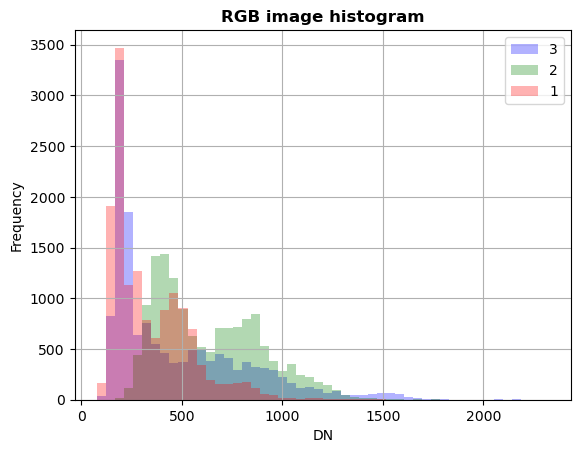

In [61]:
show_hist(
    img, bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="RGB image histogram")

### Masks
We collect raster files for the masks

In [40]:
tiles_mask_list = list_mask_files(MASKS_DATA_DIR, start_tile_index, end_tile_index)
len(tiles_mask_list)

2

In [41]:
num_masks = print_masks_list(tiles_mask_list)
print('Number of masks: {:d}'.format(num_masks))

S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55_reference_map.tif


S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45_reference_map.tif
S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46_reference_map.tif


Number of masks: 4


In [42]:
mask = tiff.imread(tiles_mask_list[0])
mask.shape

(2, 120, 120)

In [50]:
mask_array = np.array(mask)
mask_array[0].shape

(120, 120)

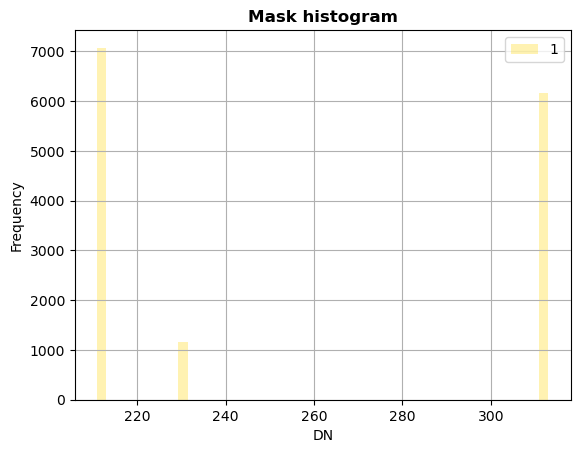

In [63]:
show_hist(
    mask_array[0], bins=50, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Mask histogram")

In [66]:
mask_array[0].max()

313

## Creating a PNG RGB dataset from TIFF images
A PNG file doesn't contain metadata so, in order to create a RGB image, we only need to use the bands from three GeoTIFF file. We also need to change the scale of the pixel values from 16 bits to 8 bits (256 values).

In [14]:
tile_index = 0
patch_index = 0
createPNG(tiles_list[tile_index][patch_index], 'data/rgb.png')

1

In [15]:
get_raster_attributes('data/rgb.png')

dtypes: uint8
Number of bands: 3
Band width: 120, band height: 120
Dataset affine transform:
 | 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: None
Bounding box 
 left: 0.00, 
 bottom: 120.00, 
 right: 120.00, 
 top: 0.00


(120,
 120,
 None,
 Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0))

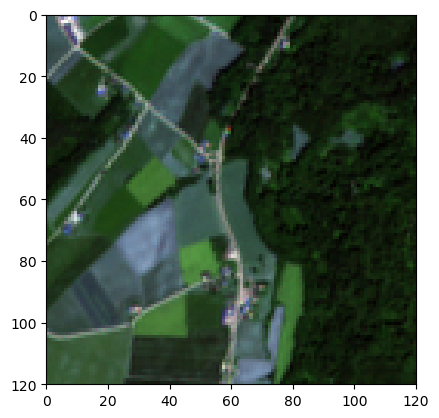

In [16]:
from rasterio.plot import show
src = rasterio.open('data/rgb.png')
show(src)
src.close()

In [17]:
pngs_list = createPNGs(tiles_list)

The PNG file already exists.
The PNG file already exists.
The PNG file already exists.
The PNG file already exists.


## Creating a PNG dataset from TIFF masks
The masks are also provided in the TIFF format so we apply the same trasformation. The difference with respect to the RGB images is that there is only one band for each mask patch. 

In [18]:
mask_path = str(tiles_mask_list[tile_index][patch_index])

In [19]:
createMaskPNG(mask_path, 'data/mask.png')

1

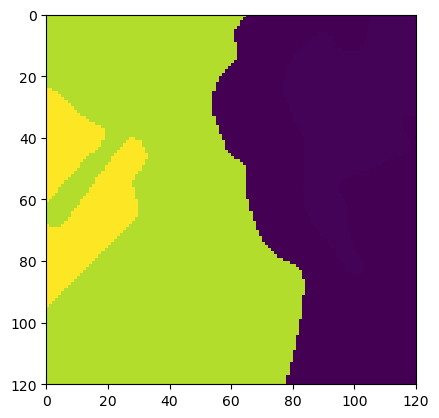

<Axes: >

In [57]:
from rasterio.plot import show
mask = rasterio.open('data/mask.png')
show(mask)

In [58]:
mask.shape

(120, 120)

In [20]:
mask_file_name = 'S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57_reference_map.tif'
tile, patch, date = read_mask_name(mask_file_name)
print('Tile: {}, Patch: {}, Date: {}'.format(tile, patch, date))

Tile: R022_T33UUP, Patch: 26_57, Date: 20170613


In [22]:
masks_png_list = createMaskPNGs(tiles_mask_list)

The PNG file already exists.
The PNG file already exists.
The PNG file already exists.
The PNG file already exists.


## Zip and unzip PNG files
We may want to compress all the PNG images into one zip file

In [33]:
rgb_zip_file = 'data/bigearthnet_pngs.zip'

In [34]:
zip_pngs(pngs_list, rgb_zip_file)

data\BigEarthNet-S2\images\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_26_57/R022_T33UUP_26_57_20170613.png
data\BigEarthNet-S2\images\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP\S2A_MSIL2A_20170613T101031_N9999_R022_T33UUP_27_55/R022_T33UUP_27_55_20170613.png
data\BigEarthNet-S2\images\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_45/R022_T34VER_00_45_20170613.png
data\BigEarthNet-S2\images\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER\S2A_MSIL2A_20170613T101031_N9999_R022_T34VER_00_46/R022_T34VER_00_46_20170613.png


we do the same for the mask PNG files

In [25]:
masks_zip_file = 'data/bigearthnet_mask_pngs.zip'

In [53]:
zip_pngs(masks_png_list, masks_zip_file)

We may also want to decompress the zip files into another folder 

In [32]:
unzip_folder = 'zip/'

In [35]:
unzip_pngs(rgb_zip_file, unzip_folder)

In [54]:
unzip_pngs(masks_zip_file, unzip_folder)

## Visualization

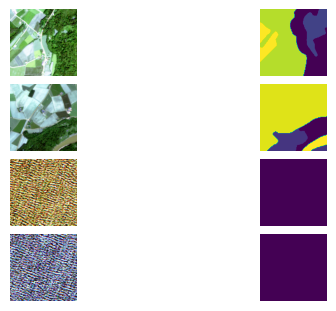

In [36]:
plot_examples(pngs_list, masks_png_list)

## Storing the PNG datasets in AWS S3
Once the PNG RGB and mask datasets are created they can be stored in the cloud, e.g. in a S3 bucket. A dataset can be uploaded and downloaded from the bucket using the scp protocol or the aws-cli command line APIs

### AWS-CLI 
send two files to a bucket. From a folder that contains a subdir with the credentials (e.g. .ssh/my_key_pair.pem)

```
$ aws s3 cp bigearthnet_pngs.zip s3://selmilab-bucket
$ aws s3 cp bigearthnet_mask_pngs.zip s3://selmilab-bucket
```

download the files from the same bucket, just reverse the paths

```
$ aws s3 cp s3://selmilab-bucket/bigearthnet_pngs.zip bigearthnet_pngs.zip
$ aws s3 cp s3://selmilab-bucket/bigearthnet_mask_pngs.zip bigearthnet_mask_pngs.zip
```
#### SCP 
download from remote

```
$ scp -i "my_aws_keypair.pem" ubuntu@ec2-15-160-237-53.eu-south-1.compute.amazonaws.com:/home/ubuntu/data/bigearthnet_mask_pngs.zip .
```

### Sharing an object in a S3 bucket
Objets such as images or zip files by default can only be accessible by the owner using the key pair. An easier way to access an objetc from S3 is by using a presigned url that can last from 1 to 720 minutes or from 1 to 12 hours.

## References
* [Sumbul et al. - BigEarthNet: A Large-Scale Benchmark Archive For Remote Sensing Image Understanding](https://arxiv.org/abs/1902.06148)
* [Clasen et al. - reBEN: Refined BigEarthNet Dataset for Remote Sensing Image Analysis](https://arxiv.org/abs/2407.03653)
* [Ulmas et al. - Segmentation of Satellite Imagery using U-Net Models for Land Cover Classification](https://arxiv.org/abs/2003.02899)
* [Walsh et al. - Using machine learning to produce a very high resolution land-cover map for Ireland](https://asr.copernicus.org/articles/18/65/2021/)